# Training a reflectorch model

First, we import the necessary methods from the `reflectorch` package, as well as othar basic Python packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from reflectorch import SAVED_MODELS_DIR, SaveBestModel, StepLR, get_trainer_by_name, get_callbacks_by_name
from reflectorch.extensions.jupyter import JPlotLoss

:::{tip}
:class: dropdown

Alternatively, we can import everything from reflectorch with
`from reflectorch import *`
:::

## The training loop

For training a model we use the `Trainer` class, which contains all the components of the training process such as the data generator, the neural network and the optimizer.

 We can initialize the trainer according to the specifications defined in a YAML configuration file using the `get_trainer_by_name` method which takes as input the name of the configuration file. If the package was installed in editable model, the configuration files are read from the `configs` directory located inside the repository, otherwise the path for the directory containing the configuration file should also be specified using the `config_dir` argument. The `load_weights` argument should be set to `False` since we want the neural network weights to be randomly initialized for a fresh training.

In [2]:
config_name = 'c1.yaml'
trainer = get_trainer_by_name(config_name, load_weights=False)

Model c1.yaml loaded. Number of parameters: 3.83 M


The trainer contains several important attributes we can inspect:

  1. The Pytorch optimizer. We can observe that the optimizer specified in the configuration is AdamW:

In [3]:
trainer.optim

AdamW (
Parameter Group 0
    amsgrad: False
    betas: [0.9, 0.998]
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0005
)

:::{note}
The learning rate can be easily changed using `trainer.set_lr(new_lr)`
:::

  2. The batch size

In [4]:
trainer.batch_size

4096

  3. The Pytorch neural network module. We see that the network is an instance of the class `SubPriorConvFCEncoder_V2`. This architecture consists of a multilayer perceptron (MLP) with residual connections, batch normalization layers and GELU activations (`trainer.model.fc`). A 1D CNN embedding network (`trainer.model.conv`) produces a latent embedding of the input batch of reflectivity curves which is concatenated with the prior bounds for the thin film parameters.

In [5]:
trainer.model

PriorInformedNetworkConvEmb(
  (embedding_net): ConvEncoder(
    (core): Sequential(
      (0): Sequential(
        (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (1): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (2): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (3): Sequential(
        (0): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU

We can add functionality to the training process using callback objects, such as:

  1. `JPlotLoss` - allows the interactive visualization of the loss curve when training inside a Jupyter Notebook, the `frequency` argument setting the refresh rate of the interactive widget

  2. `StepLR` - implements a learning rate scheduler which decreases the learning rate in steps (after a number of iterations defined by `step_size` the learning rate is multiplied by `gamma`. Other types of learning rate schedulers can alternatively be used, such as `CyclicLR` or `ReduceLrOnPlateau`. 

  3. `SaveBestModel` - it enables the periodic saving of the weights of the neural network during training. After a number of iterations defined by the `freq` argument, the weights of the neural network are saved at the specified `path` if the current average loss (computed over the last `average` iterations) is lower than the loss for the previous save. The history of the losses and learning rate values is also saved.

When the package is installed in editable mode, the default save path is relative to the repository directory (defined by `SAVED_MODELS_DIR`). 

In [6]:
save_model_name = 'model_' + config_name + '.pt'
save_path = str(SAVED_MODELS_DIR / save_model_name)

We group the callback objects together in a touple:

In [7]:
callbacks = (
    JPlotLoss(frequency=10), 
    StepLR(step_size=5000, gamma=0.1, last_epoch=-1), 
    SaveBestModel(path=save_path, freq=100, average=10),
)

:::{note}
The callbacks can also be initialized directly from the configuration file:
`callbacks = get_callbacks_by_name(config_name)`
:::

The training process is initiated by invoking the `train` method of the trainer. This method accepts parameters including the previously defined tuple of callbacks, as well as the number of iterations (batches). Notably, a new batch of data is generated at each iteration, the training taking place in a "one-epoch regime".

```python
trainer.train(num_batches=1000, callbacks=callbacks)
```

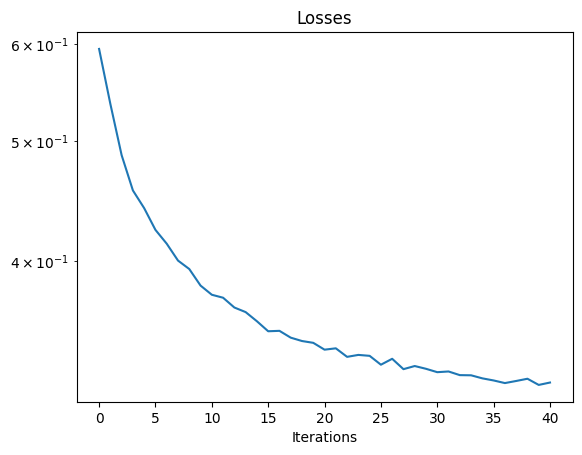

KeyboardInterrupt: 

In [8]:
#trainer.train(num_batches=100, callbacks=callbacks)

After training, the history of the losses and learning rates can be accessed via `trainer.losses` and `trainer.lrs`. We can also find them together with the model state_dict in the saved dictionary:

In [8]:
torch.load(save_path).keys()

dict_keys(['model', 'lrs', 'losses', 'prev_save', 'batch_num', 'best_loss'])

:::{tip}
:class: dropdown

The saved weights can be loaded into a compatible neural network (`net`) as:

```python
saved_dict = torch.load(save_path)
model_state_dict = saved_dict['model']
net.load_state_dict(model_state_dict)
```

:::

## Customizing the YAML configuration for training

In the following we show how the YAML configuration file can be customized.

```{dropdown} Sample YAML configuration
```yaml

general:
  name: c1
  root_dir: null
  
dset:
  prior_sampler:
    cls: SubpriorParametricSampler
    kwargs:
      param_ranges:
        thicknesses: [0., 500.]
        roughnesses: [0., 60.]
        slds: [-25., 25.]
      bound_width_ranges:
        thicknesses: [1.0e-2, 500.]
        roughnesses: [1.0e-2, 60.]
        slds: [ 1.0e-2, 4.]
      model_name: standard_model
      max_num_layers: 2
      constrained_roughness: true
      max_thickness_share: 0.5
      logdist: false
      
  q_generator:
    cls: ConstantQ
    kwargs:
      q: [0.02, 0.15, 128]
      remove_zero: false
      fixed_zero: true
      
  intensity_noise:
    cls: BasicExpIntensityNoise
    kwargs:
      relative_errors: [0.0, 0.2]
      abs_errors: 0.0
      consistent_rel_err: false
      logdist: false
      apply_shift: true
      shift_range: [-0.3, 0.3]
      apply_scaling: true
      scale_range: [-0.02, 0.02]

  q_noise:
    cls: BasicQNoiseGenerator
    kwargs:
      shift_std: 1.0e-3
      noise_std: [0., 1.0e-3] #[0., 1.0e-3]
      
  curves_scaler:
    cls: LogAffineCurvesScaler
    kwargs:
      weight: 0.2
      bias: 1.0
      eps: 1.0e-10

model:
  encoder:
    cls: PriorInformedNetworkConvEmb
    pretrained_name: null
    kwargs:
      in_channels: 1
      hidden_channels: [32, 64, 128, 256, 512]
      dim_embedding: 128
      dim_avpool: 1
      embedding_net_activation: 'gelu'
      use_batch_norm: true
      dim_out: 8
      layer_width: 512
      num_blocks: 6
      repeats_per_block: 2
      mlp_activation: 'gelu'
      dropout_rate: 0.0 
      pretrained_embedding_net: null
       
training:
  num_iterations: 10000
  batch_size: 4096
  lr: 1.0e-4
  grad_accumulation_steps: 1
  clip_grad_norm_max: null
  train_with_q_input: False
  update_tqdm_freq: 1
  optimizer: AdamW
  trainer_kwargs:
    optim_kwargs:
      betas: [0.9, 0.999]
      weight_decay: 0.0005
  callbacks:
    save_best_model:
      enable: true
      freq: 500
    lr_scheduler:
      cls: StepLR
      kwargs:
        step_size: 500
        gamma: 0.5
  logger:
    use_neptune: false
```

The `general` key, contains the following subkeys:

- `name` - name used for saving the model
- `root` - path to the root directory, defaults to the package directory

```yaml
general:
  name: c1
  root_dir: null
```

The `model` key defines the neural network architecture. Its `encoder` subkey, contains the following subkeys:

- `cls` - the class of the neural network
- `pretrained_name` - the name of a pretrained model used to initialize the weights (optional)
- `kwargs` - the keyword arguments for the provided class

The `PriorInformedNetworkConvEmb` class has the following keyword arguments:
- `in_channels` - the number of input channels of the 1D CNN (1 for reflectivity curves)
- `hidden_channels` - list with the number of channels for each layer of the 1D CNN
- `dim_embedding` - the dimension of the embedding produced by the 1D CNN
- `dim_avpool` - the output size of the adaptive average pooling layer (it scales the input size of the linear layer which produces the embedding as avpool * hidden_dims[-1])
- `embedding_net_activation` - the type of activation function in the 1D CNN
- `use_batch_norm` - whether to use batch normalization (in both the 1D CNN and the MLP)
- `dim_out` - the dimension of the output produced by the MLP (i.e. the number of thin film parameters to be predicted)
- `layer_width` - the width (i.e. number of neurons) of a linear layer in the MLP
- `num_blocks` - the number of residual blocks in the MLP
- `repeats_per_block` - the number of normalization/activation/linear repeats in a block
- `mlp_activation` - the type of activation function in the MLP
- `dropout_rate` - dropout rate for each block
- `pretrained_embedding_net` - the name of a pretrained model used to initialize the weights of the 1D CNN (optional)


```yaml

model:
  encoder:
    cls: PriorInformedNetworkConvEmb
    pretrained_name: null
    kwargs:
      in_channels: 1
      hidden_channels: [32, 64, 128, 256, 512]
      dim_embedding: 128
      dim_avpool: 1
      embedding_net_activation: 'gelu'
      use_batch_norm: true
      dim_out: 8
      layer_width: 512
      num_blocks: 6
      repeats_per_block: 2
      mlp_activation: 'gelu'
      dropout_rate: 0.0 
      pretrained_embedding_net: null
  
```

The `training` key can be used to customize the training settings:

- `num_iterations` - the total number of training iterations
- `batch_size` - the batch size (number of curves generated at each iteration)
- `lr` - the initial learning rate
- `grad_accumulation_steps` - if larger than 1, training is performed using gradient accumulation with the chosen number of steps
- `clip_grad_norm_max` - the maximum norm for gradient clipping (optional)
- `train_with_q_input` - must be set to `True` if the q-values are also used as input (i.e. when the FNO embedding network is used)
- `update_tqdm_freq` - the frequency for updating the [tqdm progress bar](https://tqdm.github.io/)
- `optimizer` - the used [Pytorch optimizer](https://pytorch.org/docs/stable/optim). Default is `AdamW`
- `trainer_kwargs` - additional trainer keyword arguments, can be used for setting the optimizer keyword arguments (`optim_kwargs`)
- `callbacks` - (optional) the callback classes together with their keyword arguments. Can also be defined directly as illustrated in the previous subsection.

```yaml

training:
  num_iterations: 10000
  batch_size: 4096
  lr: 1.0e-4
  grad_accumulation_steps: 1
  clip_grad_norm_max: null
  train_with_q_input: False
  update_tqdm_freq: 1
  optimizer: AdamW
  trainer_kwargs:
    optim_kwargs:
      betas: [0.9, 0.999]
      weight_decay: 0.0005
  callbacks:
    save_best_model:
      enable: true
      freq: 500
    lr_scheduler:
      cls: StepLR
      kwargs:
        step_size: 500
        gamma: 0.5
  logger:
    use_neptune: false
        
```